## Input Data

In [1]:
import atlite
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import time
from shapely.geometry import Point
import matplotlib.pyplot as plt
from enum import Enum
from sklearn import svm
from sklearn.metrics import accuracy_score

# Resources Paths
paths = {"era5_eu_2013": "resources/europe-2013-era5.nc",
         "era5_tutorial": "resources/europe-2013-era5-tutorial.nc",
         "offshore_shape": "resources/regions_offshore_elec_s_37.geojson",
         "onshore_shape": "resources/regions_onshore_elec_s_37.geojson",
         "capfacs": "resources/capfacs_37.csv"}

The ***europe-2013-era5.nc*** NetCDF4 file contains the Era5 data consisting of <code>height</code>, <code>wnd100m</code>, <code>roughness</code>, <code>influx_toa</code>, <code>influx_direct</code>, <code>influx_diffuse</code>, <code>albedo</code>, <code>temperature</code>, <code>soiltemperature</code> and <code>runoff</code>. The data is spatially distributed by 0.3° longitude and latitude and hourly time resolution. For a description of the variables see the [documentation](https://pypsa-eur.readthedocs.io/en/latest/preparation/build_cutout.html)

In [2]:
era_data = xr.open_dataset(filename_or_obj=paths["era5_eu_2013"], engine="netcdf4")
era_data

<xarray.Dataset>
Dimensions:           (x: 157, y: 131, time: 8760)
Coordinates:
  * x                 (x) float64 -12.0 -11.7 -11.4 -11.1 ... 34.2 34.5 34.8
  * y                 (y) float64 33.0 33.3 33.6 33.9 ... 71.1 71.4 71.7 72.0
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
    lon               (x) float64 ...
    lat               (y) float64 ...
Data variables:
    height            (y, x) float32 ...
    wnd100m           (time, y, x) float32 ...
    roughness         (time, y, x) float32 ...
    influx_toa        (time, y, x) float32 ...
    influx_direct     (time, y, x) float32 ...
    influx_diffuse    (time, y, x) float32 ...
    albedo            (time, y, x) float32 ...
    temperature       (time, y, x) float32 ...
    soil temperature  (time, y, x) float32 ...
    runoff            (time, y, x) float32 ...
Attributes:
    module:             era5
    prepared_features:  ['runoff', 'height', 'wind', 'influx', 'temperature']
    chunksize_time:     100
    dx:                 0.3
    dy:                 0.3

In [3]:
# era_data["height"].sel(x= 34.5, y="33.0")
xyz = era_data["wnd100m"].sel(x=34.5, y=33.0)[0]
xyz.values

array(6.5777497, dtype=float32)

In [4]:
era_cutout = atlite.Cutout(paths["era5_eu_2013"])
era_cutout

<Cutout "europe-2013-era5">
 x = -12.00 ⟷ 34.80, dx = 0.30
 y = 33.00 ⟷ 72.00, dy = 0.30
 time = 2013-01-01 ⟷ 2013-12-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

The ***regions_onshore_elec_s_37.geojson*** and ***regions_offshore_elec_s_37.geojson*** file describes the shape of the different clusters/voronoi cells. Here there are only 37 cells which corresponds to the country borders.

In [5]:
gdf_onshore = gpd.read_file(paths["onshore_shape"])
gdf_onshore

,name,geometry
0,AL0 0,"POLYGON ((20.32207 39.91318, 20.39703 39.81809..."
1,AT0 0,"POLYGON ((14.94402 46.83544, 15.00447 46.63686..."
2,BA0 0,"POLYGON ((17.62996 45.15735, 17.68474 45.16396..."
3,BE0 0,"POLYGON ((5.71028 49.53109, 5.67555 49.53781, ..."
4,BG0 0,"POLYGON ((24.00074 41.46414, 23.94989 41.43758..."
5,CH0 0,"POLYGON ((6.85093 46.04965, 6.84855 46.08504, ..."
6,CZ0 0,"POLYGON ((16.91052 48.63078, 16.89667 48.69698..."
7,DE0 0,"MULTIPOLYGON (((8.45827 47.63988, 8.51493 47.6..."
8,DK0 0,"MULTIPOLYGON (((9.61036 54.90323, 9.62993 54.9..."
9,DK4 0,"POLYGON ((11.71762 55.92084, 11.66310 55.90717..."


In [6]:
gdf_onshore.explore(legend=True)

In [7]:
gdf_offshore = gpd.read_file(paths["offshore_shape"])
gdf_offshore

,name,geometry
0,AL0 0,"POLYGON ((19.98542 39.69475, 20.01003 39.69120..."
1,BE0 0,"POLYGON ((3.25367 51.34858, 3.10403 51.31485, ..."
2,BG0 0,"POLYGON ((29.34583 42.24111, 28.32389 41.99778..."
3,DE0 0,"MULTIPOLYGON (((14.22389 53.70083, 13.95916 53..."
4,DK0 0,"POLYGON ((9.99277 55.70499, 10.04583 55.75027,..."
5,DK4 0,"MULTIPOLYGON (((12.93400 54.83381, 12.74997 54..."
6,EE6 0,"POLYGON ((23.72555 58.74471, 23.53527 58.74180..."
7,ES0 0,"MULTIPOLYGON (((-5.36028 35.91625, -5.39555 35..."
8,ES2 0,"POLYGON ((1.87083 37.64028, 1.73314 37.62605, ..."
9,FI4 0,"MULTIPOLYGON (((23.43159 59.95382, 23.56135 59..."


In [8]:
gdf_offshore.explore(legend=True)

The ***The capfacs_37.csv*** file describes the capacity factors for every country (37 nodes) for the year 2013 in an hourly resolution.

In [9]:
df = pd.read_csv(paths["capfacs"])
df

,snapshot,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 ror,AT0 0 solar,BA0 0 onwind,BA0 0 solar,BE0 0 offwind-ac,...,SE4 0 onwind,SE4 0 ror,SE4 0 solar,SI0 0 offwind-ac,SI0 0 onwind,SI0 0 ror,SI0 0 solar,SK0 0 onwind,SK0 0 ror,SK0 0 solar
0,2013-01-01 00:00:00,0.003291,0.001469,0.0,0.163262,0.224456,0.0,0.007340,0.0,1.000000,...,0.459609,0.626955,0.0,0.000000,0.055146,0.344668,0.0,0.361009,0.106197,0.0
1,2013-01-01 01:00:00,0.002103,0.000000,0.0,0.171340,0.224369,0.0,0.007939,0.0,0.999998,...,0.463265,0.625502,0.0,0.000000,0.052605,0.344657,0.0,0.368912,0.106012,0.0
2,2013-01-01 02:00:00,0.000000,0.000000,0.0,0.171035,0.224300,0.0,0.007829,0.0,0.993941,...,0.463777,0.624810,0.0,0.000000,0.052222,0.344593,0.0,0.382949,0.105968,0.0
3,2013-01-01 03:00:00,0.000000,0.000000,0.0,0.169685,0.224249,0.0,0.005766,0.0,0.916094,...,0.463041,0.623794,0.0,0.000000,0.050762,0.344626,0.0,0.388344,0.106215,0.0
4,2013-01-01 04:00:00,0.000000,0.000000,0.0,0.159757,0.224213,0.0,0.004262,0.0,0.704786,...,0.457253,0.623085,0.0,0.000000,0.047285,0.344607,0.0,0.409303,0.106364,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2013-12-31 19:00:00,0.029235,0.024321,0.0,0.109127,0.275353,0.0,0.001076,0.0,0.998922,...,0.358191,0.469586,0.0,0.027877,0.001708,0.696975,0.0,0.125735,0.157729,0.0
8756,2013-12-31 20:00:00,0.034024,0.031357,0.0,0.120485,0.275159,0.0,0.001090,0.0,0.965757,...,0.324709,0.469395,0.0,0.023567,0.000000,0.696262,0.0,0.142431,0.157817,0.0
8757,2013-12-31 21:00:00,0.037104,0.034522,0.0,0.128186,0.274975,0.0,0.001062,0.0,0.852484,...,0.288415,0.469208,0.0,0.000000,0.004891,0.695524,0.0,0.153930,0.157899,0.0
8758,2013-12-31 22:00:00,0.029730,0.027419,0.0,0.124740,0.274784,0.0,0.001351,0.0,0.776442,...,0.268695,0.469028,0.0,0.000000,0.009091,0.694665,0.0,0.163442,0.157945,0.0


## Creating training and testing dataset for the prediction

<!---[Atlite](https://atlite.readthedocs.io/en/latest/) calculates deterministically the capacity factors for renewable energy sources based on the era5 dataset.

We want to do determine the capacity factors as! well, but in a probabilistic way.--->

### 1. Mapping of coordinates to the regions

In [10]:
dimX, dimY, dimT = era_data.sizes.values()

# list of all coordinates that are within the region
# regions_onshore = [[] for _ in range(gdf_onshore.shape[0])]
# regions_offshore = [[] for _ in range(gdf_offshore.shape[0])]
de_coords = []

In [11]:
t1 = time.time()
s = ""

i5 = 0
for y in range(dimY):
    for x in range(dimX):
        point = Point(era_data.coords['x'].values[x], era_data.coords['y'].values[y])

        i5 += 1
        if (i5) % 100 == 0:
            print("checking " + str(point) + " " + str(i5) + " of " + str(dimY*dimX))

# Germany
        polygon = gdf_onshore.iloc[7].geometry
        if point.within(polygon):
            de_coords.append((point.x, point.y))
            break


# for y in range(dimY):
#      with open("resources/xy_to_region.txt", "a") as text_file:
#          s = ''.join(xy_to_region[dimY - 1 - y])
#          text_file.write("%s \n" %s)

# TODO: Save and load mapping

t2 = time.time()

print("Calculation duration:", (t2-t1), " seconds")

checking POINT (17.7 33) 100 of 20567
checking POINT (0.6 33.3) 200 of 20567
checking POINT (30.6 33.3) 300 of 20567
checking POINT (13.5 33.6) 400 of 20567
checking POINT (-3.6 33.9) 500 of 20567
checking POINT (26.4 33.9) 600 of 20567
checking POINT (9.3 34.2) 700 of 20567
checking POINT (-7.8 34.5) 800 of 20567
checking POINT (22.2 34.5) 900 of 20567
checking POINT (5.1 34.8) 1000 of 20567
checking POINT (-12 35.1) 1100 of 20567
checking POINT (18 35.1) 1200 of 20567
checking POINT (0.9 35.4) 1300 of 20567
checking POINT (30.9 35.4) 1400 of 20567
checking POINT (13.8 35.7) 1500 of 20567
checking POINT (-3.3 36) 1600 of 20567
checking POINT (26.7 36) 1700 of 20567
checking POINT (9.6 36.3) 1800 of 20567
checking POINT (-7.5 36.6) 1900 of 20567
checking POINT (22.5 36.6) 2000 of 20567
checking POINT (5.4 36.9) 2100 of 20567
checking POINT (-11.7 37.2) 2200 of 20567
checking POINT (18.3 37.2) 2300 of 20567
checking POINT (1.2 37.5) 2400 of 20567
checking POINT (31.2 37.5) 2500 of 20567

### 2. Creating datasets

In [12]:
'''

# Wind input features
X_height_de = np.full(dimT, 0, np.float32)
X_wnd100m_de = np.full(dimT, 0, np.float32)
X_roughness_de = np.full(dimT, 0, np.float32)
# X_temperature = []

# Solar input features
X_influx_toa_de = np.full(dimT, 0, np.float32)
X_influx_direct_de = np.full(dimT, 0, np.float32)
X_influx_diffuse_de = np.full(dimT, 0, np.float32)
X_temperature_de = np.full(dimT, 0, np.float32)
# X_Albedo

# Capacity factor
Y_capfac_de_solar = df["DE0 0 solar"].values
Y_capfac_de_offwind_ac = df["DE0 0 offwind-ac"].values
Y_capfac_de_offwind_dc = df["DE0 0 offwind-dc"].values
Y_capfac_de_onwind = df["DE0 0 onwind"].values


# class CoordReductionMethod(Enum):
#     MEAN = 1
#     MEDIAN = 2


height_sum = 0
for point in de_coords:
    val = era_data["height"].sel(x=point[0], y=point[1]).item(0)
    height_sum += val
height_mean = height_sum / len(de_coords)
X_height_de = np.full(dimT, height_mean, np.float32)


for t in range(dimT):
    print(str(t + 1) + " of " + str(dimT))
    wnd_sum = 0
    roughness_sum = 0
    influx_toa_sum = 0
    influx_direct_sum = 0
    influx_diffuse_sum = 0
    temperature_sum = 0

    for point in de_coords:
        val_wnd = era_data["wnd100m"].sel(x=point[0], y=point[1]).item(t)
        val_roughness = era_data["roughness"].sel(x=point[0], y=point[1]).item(t)
        val_influx_toa = era_data["influx_toa"].sel(x=point[0], y=point[1]).item(t)
        val_influx_direct = era_data["influx_direct"].sel(x=point[0], y=point[1]).item(t)
        val_influx_diffuse = era_data["influx_diffuse"].sel(x=point[0], y=point[1]).item(t)
        val_temperature = era_data["temperature"].sel(x=point[0], y=point[1]).item(t)

        wnd_sum += val_wnd
        roughness_sum += val_roughness
        influx_toa_sum += val_influx_toa
        influx_direct_sum += val_influx_direct
        influx_diffuse_sum += val_influx_diffuse
        temperature_sum += val_temperature

    X_wnd100m_de[t] = wnd_sum / len(de_coords)
    X_roughness_de[t] = roughness_sum / len(de_coords)
    X_influx_toa_de[t] = influx_toa_sum / len(de_coords)
    X_influx_direct_de[t] = influx_direct_sum / len(de_coords)
    X_influx_diffuse_de[t] = influx_diffuse_sum / len(de_coords)
    X_temperature_de[t] = temperature_sum / len(de_coords)

'''

'\n\n# Wind input features\nX_height_de = np.full(dimT, 0, np.float32)\nX_wnd100m_de = np.full(dimT, 0, np.float32)\nX_roughness_de = np.full(dimT, 0, np.float32)\n# X_temperature = []\n\n# Solar input features\nX_influx_toa_de = np.full(dimT, 0, np.float32)\nX_influx_direct_de = np.full(dimT, 0, np.float32)\nX_influx_diffuse_de = np.full(dimT, 0, np.float32)\nX_temperature_de = np.full(dimT, 0, np.float32)\n# X_Albedo\n\n# Capacity factor\nY_capfac_de_solar = df["DE0 0 solar"].values\nY_capfac_de_offwind_ac = df["DE0 0 offwind-ac"].values\nY_capfac_de_offwind_dc = df["DE0 0 offwind-dc"].values\nY_capfac_de_onwind = df["DE0 0 onwind"].values\n\n\n# class CoordReductionMethod(Enum):\n#     MEAN = 1\n#     MEDIAN = 2\n\n\nheight_sum = 0\nfor point in de_coords:\n    val = era_data["height"].sel(x=point[0], y=point[1]).item(0)\n    height_sum += val\nheight_mean = height_sum / len(de_coords)\nX_height_de = np.full(dimT, height_mean, np.float32)\n\n\nfor t in range(dimT):\n    print(str(t 

In [13]:
# Wind input features
X_height_de = np.full(dimT, 0, np.float32)
X_wnd100m_de = np.full(dimT, 0, np.float32)
X_roughness_de = np.full(dimT, 0, np.float32)
# X_temperature = []

# Solar input features
X_influx_toa_de = np.full(dimT, 0, np.float32)
X_influx_direct_de = np.full(dimT, 0, np.float32)
X_influx_diffuse_de = np.full(dimT, 0, np.float32)
X_temperature_de = np.full(dimT, 0, np.float32)
# X_Albedo

# Capacity factor
Y_capfac_de_solar = df["DE0 0 solar"].values
Y_capfac_de_offwind_ac = df["DE0 0 offwind-ac"].values
Y_capfac_de_offwind_dc = df["DE0 0 offwind-dc"].values
Y_capfac_de_onwind = df["DE0 0 onwind"].values


# class CoordReductionMethod(Enum):
#     MEAN = 1
#     MEDIAN = 2


height_sum = 0
for point in de_coords:
    val = era_data["height"].sel(x=point[0], y=point[1]).item(0)
    height_sum += val
height_mean = height_sum / len(de_coords)
X_height_de = np.full(dimT, height_mean, np.float32)




for point in de_coords:
    val_wnd = era_data["wnd100m"].sel(x=point[0], y=point[1]).values
    val_roughness = era_data["roughness"].sel(x=point[0], y=point[1]).values
    val_influx_toa = era_data["influx_toa"].sel(x=point[0], y=point[1]).values
    val_influx_direct = era_data["influx_direct"].sel(x=point[0], y=point[1]).values
    val_influx_diffuse = era_data["influx_diffuse"].sel(x=point[0], y=point[1]).values
    val_temperature = era_data["temperature"].sel(x=point[0], y=point[1]).values

    X_wnd100m_de += val_wnd
    X_roughness_de += val_roughness
    X_influx_toa_de += val_influx_toa
    X_influx_direct_de += val_influx_direct
    X_influx_diffuse_de += val_influx_diffuse
    X_temperature_de += val_temperature

X_wnd100m_de /= len(de_coords)
X_roughness_de /= len(de_coords)
X_influx_toa_de /= len(de_coords)
X_influx_direct_de /= len(de_coords)
X_influx_diffuse_de /= len(de_coords)
X_temperature_de /= len(de_coords)


Text(0, 0.5, 'wnd100m')

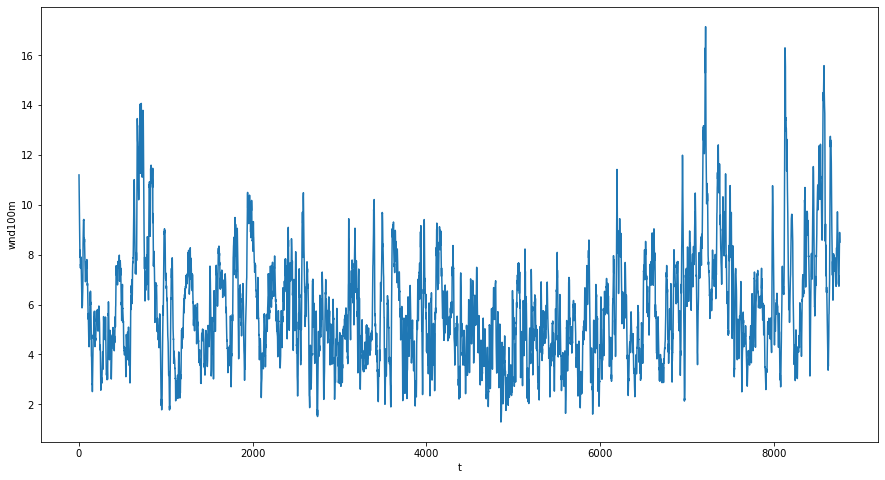

In [14]:
plt.figure(figsize=(15,8))
plt.plot(X_wnd100m_de)
plt.xlabel("t")
plt.ylabel("wnd100m")

Text(0, 0.5, 'Roughness')

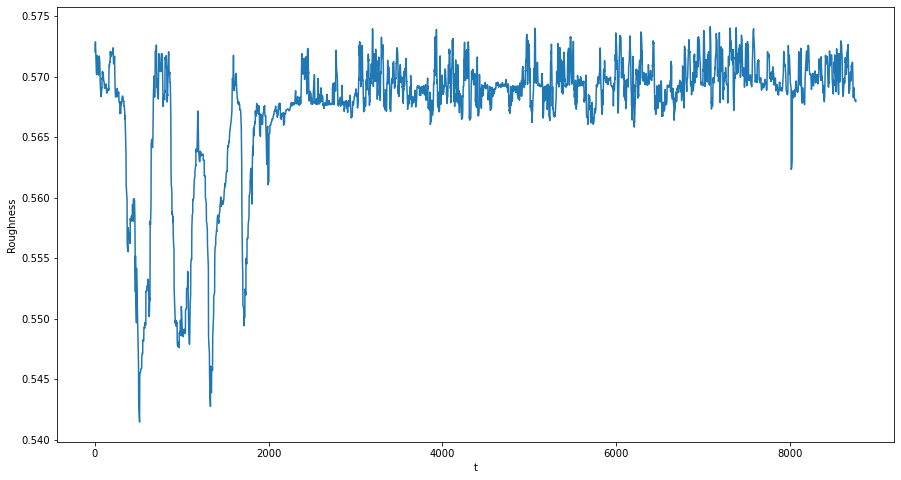

In [15]:
plt.figure(figsize=(15,8))
plt.plot(X_roughness_de)
plt.xlabel("t")
plt.ylabel("Roughness")

### SVR DE onshore wind

In [16]:
# Trainingsset X is an array of shape (n_samples, n_features)
# (8760, 2) ---> [[x_wind_1, x_rough_1], [x_wind_2, x_rough_2], ... , [x_wind_8760, x_rough_8760]]
X_train = np.column_stack((X_wnd100m_de, X_roughness_de))
Y_train = Y_capfac_de_onwind
regr = svm.SVR()
regr.fit(X_train, Y_train)
Y_predict = regr.predict(X_train)

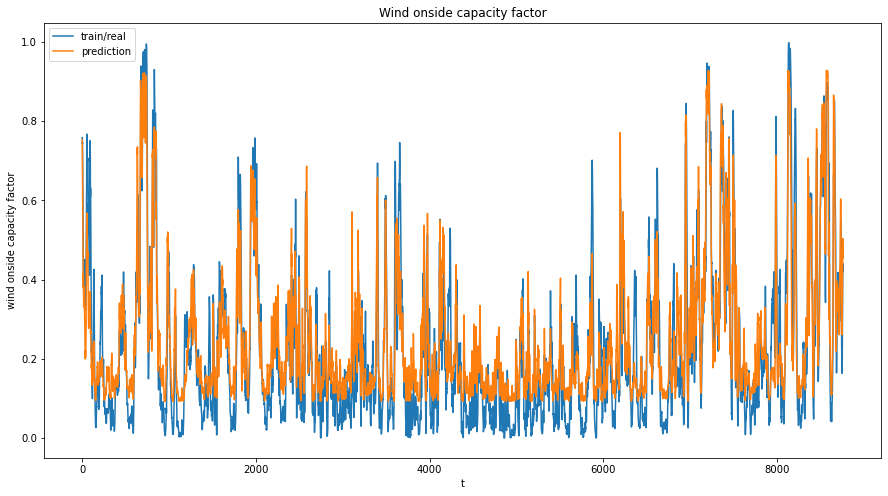

In [17]:
plt.figure(figsize=(15,8))
plt.plot(Y_train, label="train/real")
plt.plot(Y_predict, label="prediction")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor")
plt.title("Wind onside capacity factor")
plt.legend()

Text(0.5, 1.0, 'Wind onside capacity factor difference')

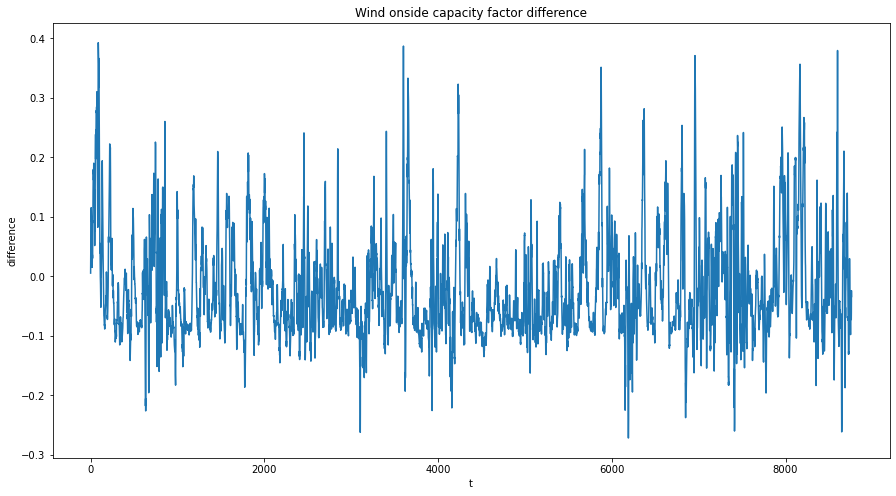

In [18]:
prediction_diff = Y_train - Y_predict

plt.figure(figsize=(15,8))
plt.plot(prediction_diff)
plt.xlabel("t")
plt.ylabel("difference")
plt.title("Wind onside capacity factor difference")

In [19]:
# The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly.
X_train = np.column_stack((X_wnd100m_de, X_roughness_de))
Y_train = Y_capfac_de_onwind
svr_rbf = svm.SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_rbf1 = svm.SVR(kernel="rbf", C=1)
svr_rbf10 = svm.SVR(kernel="rbf", C=10)
svr_rbf100 = svm.SVR(kernel="rbf", C=100)
svr_rbf1000 = svm.SVR(kernel="rbf", C=1000)
svr_lin = svm.SVR(kernel="linear", C=100, gamma="auto")
svr_poly = svm.SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

svr_rbf1.fit(X_train, Y_train)
Y_predict1 = svr_rbf1.predict(X_train)

svr_rbf10.fit(X_train, Y_train)
Y_predict10 = svr_rbf10.predict(X_train)

svr_rbf100.fit(X_train, Y_train)
Y_predict100 = svr_rbf100.predict(X_train)

svr_rbf1000.fit(X_train, Y_train)
Y_predict1000 = svr_rbf1000.predict(X_train)

print(svr_rbf1.score(X_train, Y_train))
print(svr_rbf10.score(X_train, Y_train))
print(svr_rbf100.score(X_train, Y_train))
print(svr_rbf1000.score(X_train, Y_train))

0.8062043723107062
0.8068662252459844
0.8077623868295863
0.8078129371352981


In [20]:
# svr_rbf1.score(X_train, X_train)
# accuracy_score(Y_train, Y_predict10)
# accuracy_score(Y_train, Y_predict100)
# accuracy_score(Y_train, Y_predict1000)

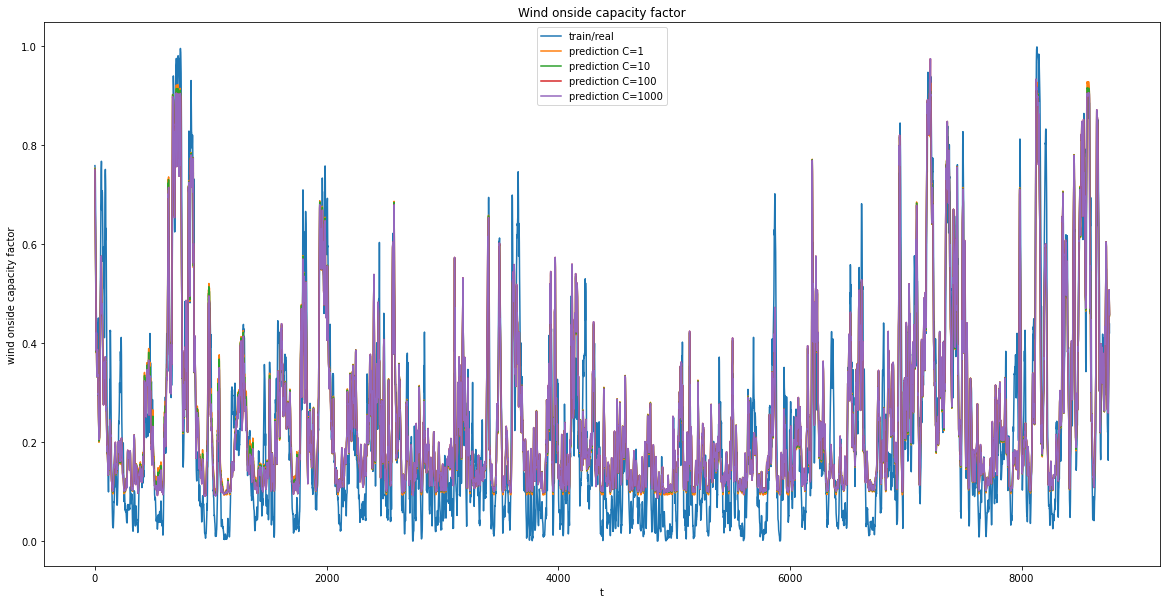

In [21]:
plt.figure(figsize=(20,10))
plt.plot(Y_train, label="train/real")
plt.plot(Y_predict1, label="prediction C=1")
plt.plot(Y_predict10, label="prediction C=10")
plt.plot(Y_predict100, label="prediction C=100")
plt.plot(Y_predict100, label="prediction C=1000")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor")
plt.title("Wind onside capacity factor")
plt.legend()

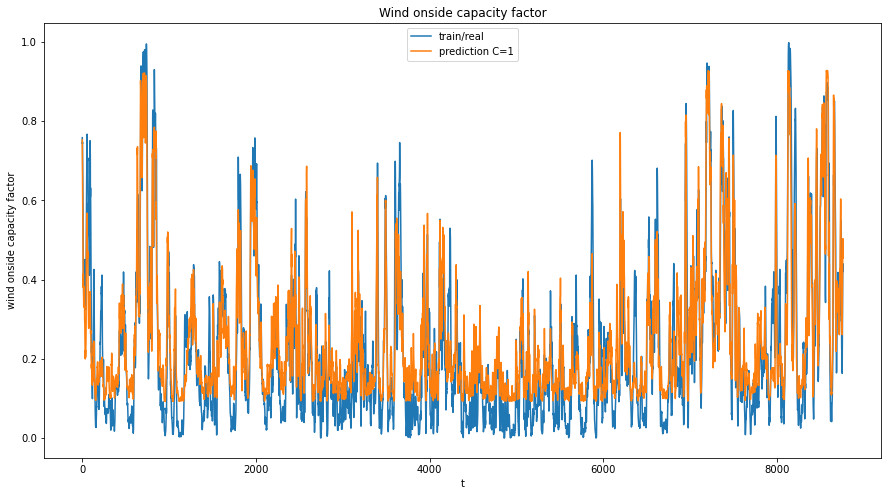

In [22]:
plt.figure(figsize=(15,8))
plt.plot(Y_train, label="train/real")
plt.plot(Y_predict1, label="prediction C=1")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor")
plt.title("Wind onside capacity factor")
plt.legend()

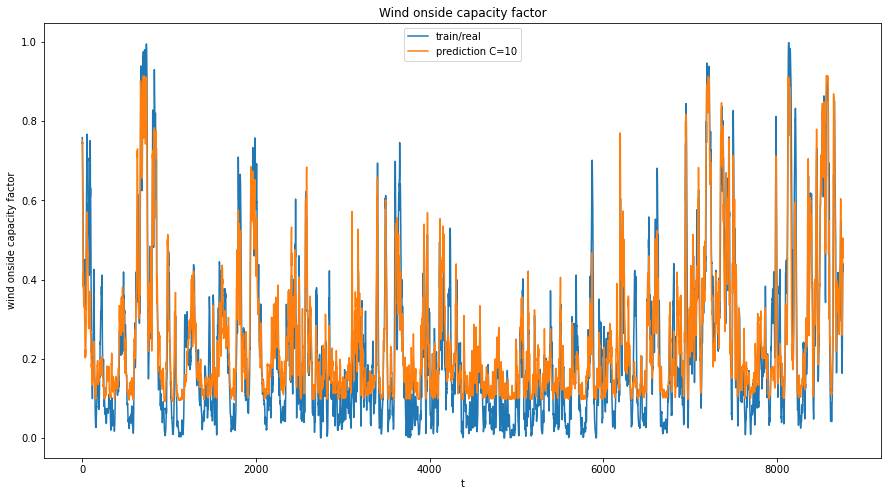

In [23]:
plt.figure(figsize=(15,8))
plt.plot(Y_train, label="train/real")
plt.plot(Y_predict10, label="prediction C=10")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor")
plt.title("Wind onside capacity factor")
plt.legend()

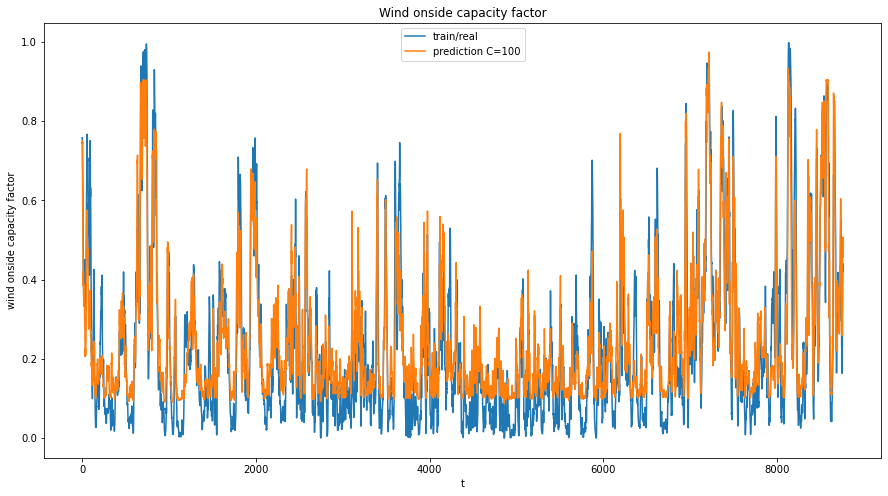

In [24]:
plt.figure(figsize=(15,8))
plt.plot(Y_train, label="train/real")
plt.plot(Y_predict100, label="prediction C=100")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor")
plt.title("Wind onside capacity factor")
plt.legend()

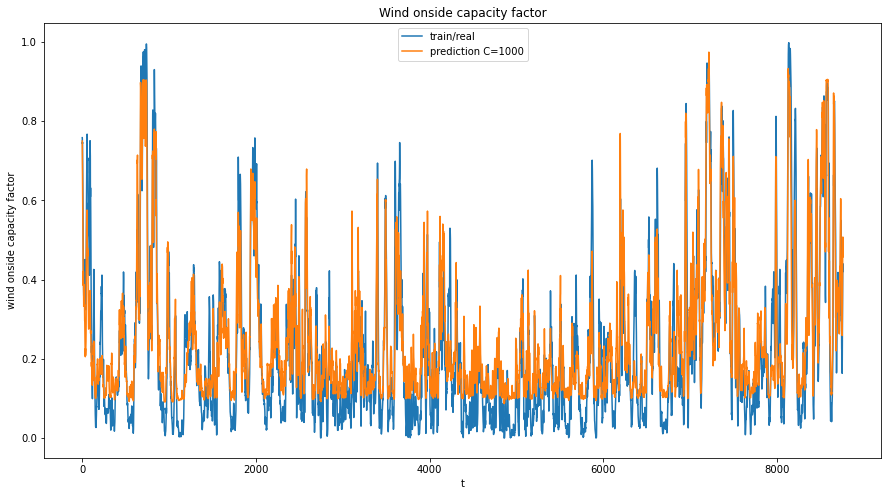

In [25]:
plt.figure(figsize=(15,8))
plt.plot(Y_train, label="train/real")
plt.plot(Y_predict100, label="prediction C=100")
plt.xlabel("t")
plt.ylabel("wind onside capacity factor")
plt.title("Wind onside capacity factor")
plt.legend()

In [26]:
# # X_train = np.column_stack((X_wnd100m_de, X_roughness_de))
# X_train = X_wnd100m_de
# Y_train = Y_capfac_de_onwind
# regr2 = svm.SVR()
# regr2.fit(X_train, Y_train)
# Y_predict = regr.predict(X_train)
#
# plt.figure(figsize=(15,8))
# plt.plot(Y_train, label="train/real")
# plt.plot(Y_predict, label="prediction")
# plt.xlabel("t")
# plt.ylabel("wind onside capacity factor")
# plt.title("Wind onside capacity factor")
# plt.legend()

### SVR DE Solar

In [27]:
X_train = np.column_stack((X_influx_toa_de, X_influx_direct_de, X_influx_diffuse_de, X_temperature_de))
Y_train = Y_capfac_de_solar
regr = svm.SVR()
regr.fit(X_train, Y_train)
Y_predict = regr.predict(X_train)

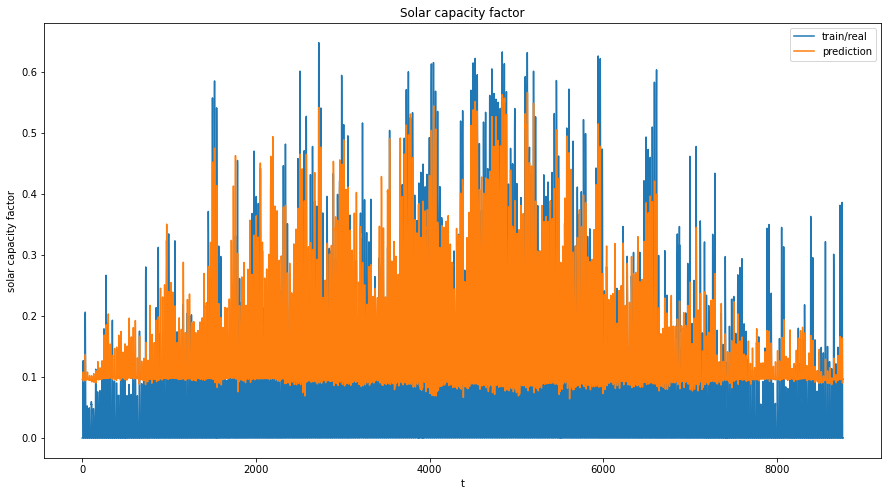

In [28]:
plt.figure(figsize=(15,8))
plt.plot(Y_train, label="train/real")
plt.plot(Y_predict, label="prediction")
plt.xlabel("t")
plt.ylabel("solar capacity factor")
plt.title("Solar capacity factor")
plt.legend()

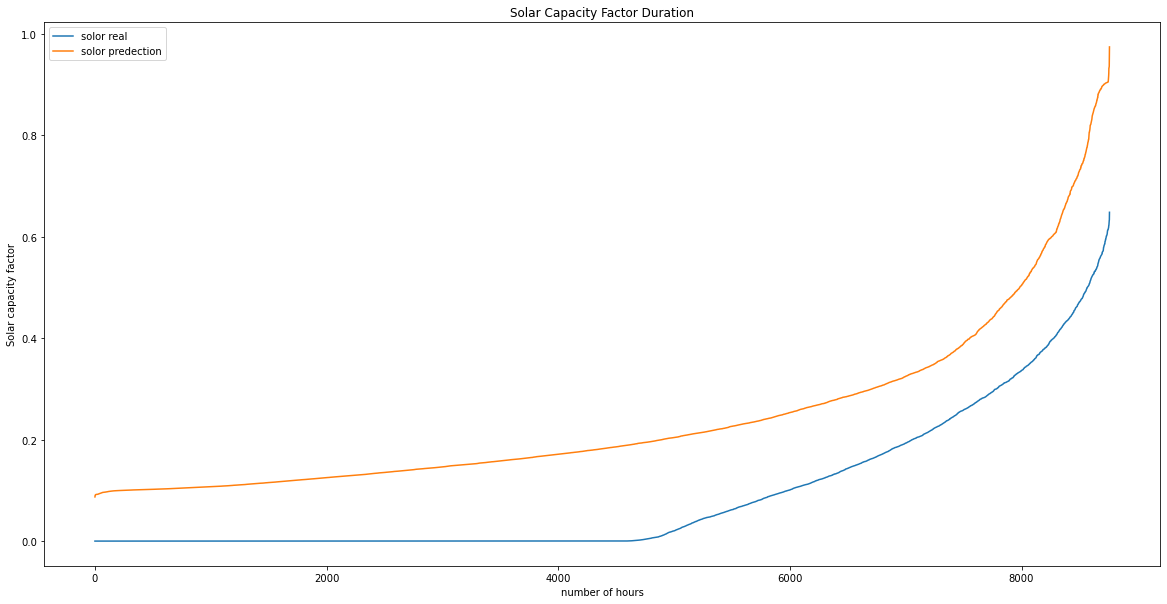

In [32]:
solar_duration_curve = np.sort(Y_capfac_de_solar)
solar_duration_curve_pred = np.sort(Y_predict100)

plt.figure(figsize=(20,10))
plt.plot(solar_duration_curve, label="solor real")
plt.plot(solar_duration_curve_pred, label="solor predection")
plt.xlabel("number of hours")
plt.ylabel("Solar capacity factor")
plt.title("Solar Capacity Factor Duration")
plt.legend()

Text(0.5, 1.0, 'solar capacity factor difference')

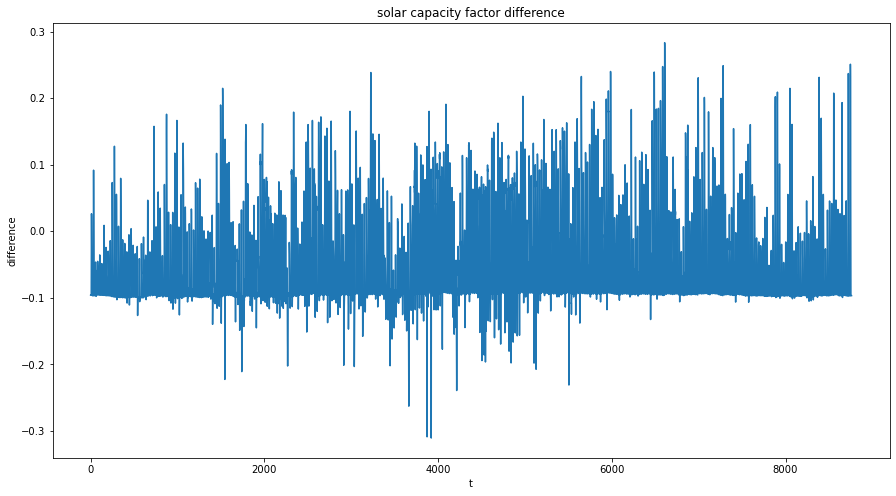

In [30]:
prediction_diff = Y_train - Y_predict

plt.figure(figsize=(15,8))
plt.plot(prediction_diff)
plt.xlabel("t")
plt.ylabel("difference")
plt.title("solar capacity factor difference")
